##Notebook initialization

In [ ]:
# Mount Google Drive
from google.colab import drive  # import drive from google colab

ROOT = "/content/drive"  # default location for the drive

drive.mount(ROOT)  # we mount the google drive at /content/drive

%cd ./drive/MyDrive/'Colab Notebooks'/StyleTransfer

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/StyleTransfer


In [ ]:
!pip install "pytorch-lightning"
!pip install "torchmetrics"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 62.0 MB/s 
     |████████████████████████████████| 418 kB 61.7 MB/s 
     |████████████████████████████████| 140 kB 72.6 MB/s 
     |████████████████████████████████| 1.1 MB 70.9 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 70.8 MB/s 
     |████████████████████████████████| 271 kB 66.9 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import glob
from PIL import Image
from tqdm.notebook import tqdm_notebook
import time
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms as T
from torchvision.models import vgg16

from torchmetrics import functional
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
seed_everything(21)

Global seed set to 21


21

In [ ]:
device  = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device available: {device}\n")
if torch.cuda.is_available():
    print(f"Number of gpus: {torch.cuda.device_count()}\n")
    print(f"Gpu(0) name: {torch.cuda.get_device_name(0)}\n")

Device available: cuda

Number of gpus: 1

Gpu(0) name: Tesla T4



## Dataset creation

In [ ]:
filelist = glob.glob('data/Humans/*.jpg')
print(len(filelist))

0


In [ ]:
class myDataStyle(torch.utils.data.Dataset):
    def __init__(self):
        self.image_names = glob.glob('data/Faces/*.jpg')
        self.transform =  T.Compose([T.Resize(256), 
                                     T.CenterCrop(224), 
                                     T.ToTensor(),
                                     T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
        self.style = self.transform(Image.open('data/trainA/neuralStyleReference.jpg').convert("RGB"))

    def __getitem__(self, index):
        image = Image.open(self.image_names[index]).convert("RGB")
        return self.transform(image), self.style

    def __len__(self):
        return len(self.image_names)

In [ ]:
dataset = myDataStyle()
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
for i,batch in enumerate(dataset):
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


## Model definition

###Utility

In [ ]:
def gramm_matrix(phi):
    (b, ch, h, w) = phi.shape
    phi = torch.reshape(phi, (b, ch, h*w))
    phi_T = torch.transpose(phi,1,2)
    G = torch.bmm(phi,phi_T) / (ch*h*w)
    return G

invTrans = T.Compose([T.Normalize(mean=[0., 0., 0.],std=[1/0.229, 1/0.224, 1/0.225]),
                      T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])

In [ ]:
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out
    
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out
    
class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

class TransformationNet(torch.nn.Module):
    def __init__(self):
        super(TransformationNet, self).__init__()
        # initial downsampling
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # final upsampling
        self.upsample1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.upsample2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.upsample3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # activation function
        self.relu = torch.nn.ReLU()
        # loss function
        self.loss_func = torch.nn.MSELoss()
        
    def forward(self, x):
        out = self.relu(self.in1(self.conv1(x)))
        out = self.relu(self.in2(self.conv2(out)))
        out = self.relu(self.in3(self.conv3(out)))
        out = self.res1(out)
        out = self.res2(out)
        out = self.res3(out)
        out = self.res4(out)
        out = self.res5(out)
        out = self.relu(self.in4(self.upsample1(out)))
        out = self.relu(self.in5(self.upsample2(out)))
        out = self.upsample3(out)
        return out
    
    def training_step(self, batch, batch_idx):
        xb = batch
        yb = xb
        pred = model(xb)
        loss = self.loss_func(pred, yb)
        return pred, loss
    
    def validation_step(self, batch, batch_idx):
        xb = batch
        yb = xb
        pred = model(xb)
        loss = self.loss_func(pred, yb)
        return pred, loss
    
    def configure_optimizers(self):
        # return optimizer
        optimizer = torch.optim.SGD(self.parameters(), lr=0.003, momentum=0.9)
        return optimizer


### Model

In [ ]:
class StyleTransferNet(nn.Module):
    def __init__(self, device='cpu'):
        super(StyleTransferNet, self).__init__()
        
        self.transform_net = TransformationNet()
        self.transform_net.to(device)
        self.feature_extractor_list = list(vgg16(pretrained = True).features)[:23]
        # freeze feature extractor
        for layer in self.feature_extractor_list:
            layer.requires_grad = False
            layer.to(device)
        # loss function
        self.lstyle_weight = [0.5/n**2 for n in [0.9*128,256,2*512,2*512]]
        self.lfeatures_weight = 2
        self.mse = nn.MSELoss()
        
    def forward(self, x):
        out = self.transform_net(x)
        return out
    
    def get_loss(self, output, original, style):
        features_out = self.get_features(output,{3,8,15,22})
        features_original = self.get_features(original,{15})
        features_style = self.get_features(style,{3,8,15,22})
        (dim_b, dim_ch, dim_h, dim_w) = features_out[1].shape
        f_loss = self.mse(features_out[2],features_original[0])/(dim_ch*dim_h*dim_w)
        s_loss1 = self.lstyle_weight[0]*torch.norm(gramm_matrix(features_out[0])-gramm_matrix(features_style[0]))
        s_loss2 = self.lstyle_weight[1]*torch.norm(gramm_matrix(features_out[1])-gramm_matrix(features_style[1]))
        s_loss3 = self.lstyle_weight[2]*torch.norm(gramm_matrix(features_out[2])-gramm_matrix(features_style[2]))
        s_loss4 = self.lstyle_weight[3]*torch.norm(gramm_matrix(features_out[3])-gramm_matrix(features_style[3]))
        total_loss = s_loss1+s_loss2+s_loss3+s_loss4 + self.lfeatures_weight*f_loss
        return total_loss
    
    def get_features(self, x, layers):
        features = []
        for n_layer, layer in enumerate(self.feature_extractor_list):
            x = layer(x)
            if n_layer in layers:
                features.append(x)
        return features
    
    def training_step(self, batch, batch_idx):
        original, style = batch
        output = self(original)
        loss = self.get_loss(output, original, style)
        return output, loss

    def configure_optimizers(self):
        # return optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [ ]:
model = StyleTransferNet(device)
model.to(device)
summary(model, input_size=(3,256,256))

opt = model.configure_optimizers()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 264, 264]               0
            Conv2d-2         [-1, 32, 256, 256]           7,808
         ConvLayer-3         [-1, 32, 256, 256]               0
    InstanceNorm2d-4         [-1, 32, 256, 256]              64
              ReLU-5         [-1, 32, 256, 256]               0
   ReflectionPad2d-6         [-1, 32, 258, 258]               0
            Conv2d-7         [-1, 64, 128, 128]          18,496
         ConvLayer-8         [-1, 64, 128, 128]               0
    InstanceNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
  ReflectionPad2d-11         [-1, 64, 130, 130]               0
           Conv2d-12          [-1, 128, 64, 64]          73,856
        ConvLayer-13          [-1, 128, 64, 64]               0
   InstanceNorm2d-14          [-1, 128,

## Training

In [ ]:
epochs = 5

hist_loss = []

for epoch in tqdm_notebook(range(epochs)):
    t0 = time.time()
    
    model.train()
    train_loss = 0.0
    counter = 0
    for original, style in tqdm_notebook(dataloader):
        original = original.to(device)
        style = style.to(device)
        pred, loss = model.training_step([original,style], counter)
        train_loss += loss.item()
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        counter += 1
        
    train_loss = train_loss/counter
    
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s):%.4f, train loss: %.6f"%(epoch, elapsed_time, train_loss)) 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

epoch: 0, time(s):604.4837, train loss: 0.000030


  0%|          | 0/872 [00:00<?, ?it/s]

epoch: 1, time(s):605.2986, train loss: 0.000019


  0%|          | 0/872 [00:00<?, ?it/s]

epoch: 2, time(s):603.3094, train loss: 0.000018


  0%|          | 0/872 [00:00<?, ?it/s]

epoch: 3, time(s):600.0282, train loss: 0.000016


  0%|          | 0/872 [00:00<?, ?it/s]

epoch: 4, time(s):600.5693, train loss: 0.000015


In [ ]:
torch.save(model.state_dict(), './models/neuralModel.ckpt')

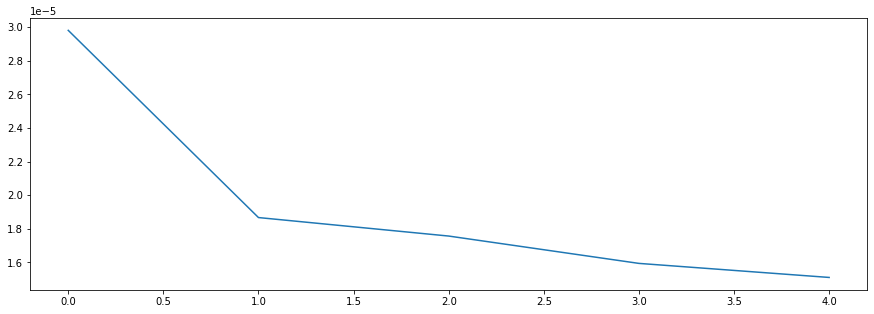

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.plot(hist_loss)

##Loading model

In [ ]:
model = StyleTransferNet(device)
checkpoint_path = './models/neuralModel.ckpt'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

##Evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


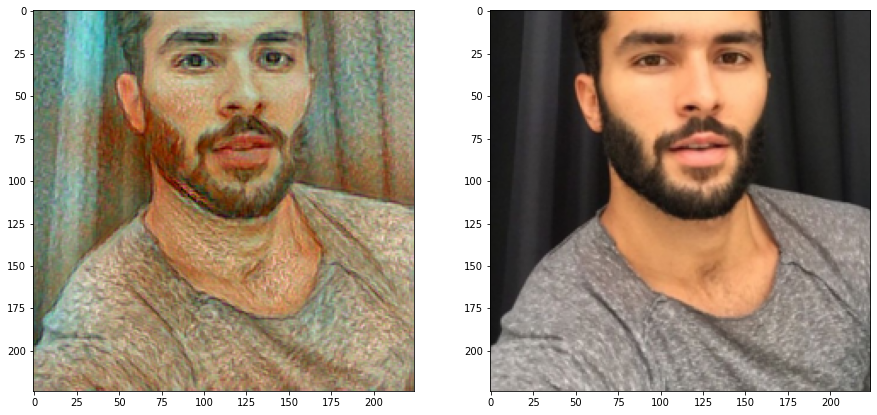

In [ ]:
invTrans = T.Compose([T.Normalize(mean=[0., 0., 0.],std=[1/0.229, 1/0.224, 1/0.225]),
                      T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])

model.eval()
model.to(device)
original = None
i=0
for image,_ in dataloader:
    original = image[0]
    image = torch.unsqueeze(image[0], dim=0)
    image = image.to(device)
    out = model(image)
    i += 1
    if i>0:
        break
    
out = np.moveaxis(np.squeeze(invTrans(out).cpu().detach().numpy()),0,-1) 
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
plt.imshow(out)

ax = fig.add_subplot(122)
original = np.moveaxis(invTrans(original).cpu().detach().numpy(),0,-1)
plt.imshow(original)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


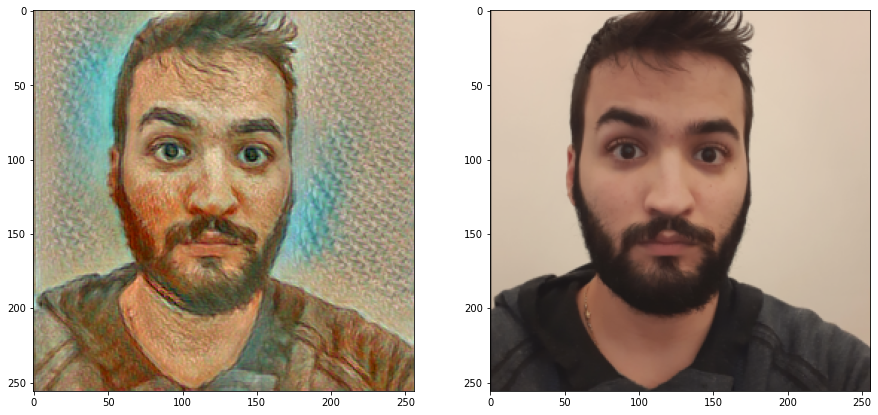

In [ ]:
model.eval()

transformation =  T.Compose([T.Resize(256), 
                              T.CenterCrop(256),
                              T.ToTensor(), 
                              T.Normalize((0.4751, 0.4488, 0.4081),(0.2702, 0.2649, 0.2792))])
image_to_transform = transformation(Image.open('marco.jpg').convert("RGB").rotate(-90))

original = image_to_transform
image_to_transform = torch.unsqueeze(image_to_transform, dim=0)
image_to_transform = image_to_transform.to(device)
out = model(image_to_transform)
    
out = np.moveaxis(np.squeeze(invTrans(out).cpu().detach().numpy()),0,-1) 
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
plt.imshow(out)

ax = fig.add_subplot(122)
original = np.moveaxis(invTrans(original).cpu().detach().numpy(),0,-1)
plt.imshow(original)